In [ ]:
## import the modul
import numpy as np

from numpy import zeros
import string
import re


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
file=open(r"drive/MyDrive/deu.txt",encoding="utf-8")
input_sentences = []                      # list to contain English (input) sentences
output_sentences = []                     # list to contain French (output) sentences

count = 0
for line in file:
    count += 1
    input_sentence, output_sentence = line.rstrip().split('\t') #  splitting the text file line
    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)

print("Number of senetence in original corpus : ",len(input_sentences)) # Number of sentences

# Limit the number of sentences to 10,000 lines (but more than 5,000 lines)
input_sentences = input_sentences[:10000]
output_sentences = output_sentences[:10000]

# Split the data into train, development and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_sentences, output_sentences, test_size=0.2, random_state=42)

# Print 100th sentence in original script for source and target language
print("\n100th senetnce in Source Language : ",X_train[100]," , Target Language : ",y_train[100])

Number of senetence in original corpus :  152820

100th senetnce in Source Language :  How kind of you!  , Target Language :  Wie nett von euch!


In [ ]:
input_sentences = []          # list containing inputs of encoder
output_sentences = []         # list containing output of decoder
output_sentences_inputs = []  # list containing input of decoder

def preprocess(seq):          # Utility function to preprocess strings
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~''' # initializing punctuations string
    # Removing punctuations in string
    for ele in seq:
        if ele in punc:
            seq = seq.replace(ele, "")
    line = seq.split()
    line = [word.lower() for word in line]
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # remove non-printable chars form each token
    line = [re_print.sub('', w) for w in line]
    return " ".join(line)

for i in range(len(X_train)):
    input_sentence = preprocess(X_train[i])
    output = y_train[i]
    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of input samples :", len(input_sentences))
print("Number of output samples:", len(output_sentences))
print("Number of input output samples:", len(output_sentences_inputs))

total_input = input_sentences +  [preprocess(line) for line in X_test]
max_input_len = max([len(txt.split()) for txt in total_input])
print("Max length for input : : ",max_input_len)
print("Max length for output:",max([len(txt.split()) for txt in output_sentences]))

unique_input_tokens = set()
for line in total_input:
    words = line.split()
    for word in words:
        unique_input_tokens.add(word)
print("Unique tokens for inputs : ",len(unique_input_tokens))

unique_output_tokens = set()
for line in output_sentences:
    words = line.split()
    for word in words:
        unique_output_tokens.add(word)
print("Unique tokens for outputs : ",len(unique_output_tokens))

Number of input samples : 8000
Number of output samples: 8000
Number of input output samples: 8000
Max length for input : :  5
Max length for output: 11
Unique tokens for inputs :  2425
Unique tokens for outputs :  5208


In [ ]:
MAX_NUM_WORDS = 20000

input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(total_input)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)


output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the input: 2425
Length of longest sentence in input: 5
Total unique words in the output: 4881
Length of longest sentence in the output: 11


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[0]:", encoder_input_sequences[0])

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post') # in the case of the decoder, the post-padding is applied
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[0]:", decoder_input_sequences[0])
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

encoder_input_sequences.shape: (8000, 5)
encoder_input_sequences[0]: [   0    0   77   65 1527]
decoder_input_sequences.shape: (8000, 11)
decoder_input_sequences[0]: [   2  148   19 2120 2121    0    0    0    0    0    0]


In [ ]:
decoder_targets_one_hot = np.zeros((len(input_sentences),max_out_len,num_words_output),dtype='float32')
print(decoder_targets_one_hot.shape)

# The final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors,
# since we will be using softmax activation function at the dense layer.
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

(8000, 11, 4882)


In [ ]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
# Encoder
LSTM_NODES =256
BATCH_SIZE = 64
EPOCHS = 100
LSTM_NODES =256

embedding_layer = Embedding(num_words, 200,  input_length=max_input_len)
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [ ]:
# Decoder
decoder_inputs_placeholder = Input(shape=(max_out_len,))
decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs_placeholder,decoder_inputs_placeholder], decoder_outputs)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 11)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 5, 200)               485200    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 11, 256)              1249792   ['input_2[0][0]']             
                                                                                              

In [12]:
history = model.fit([encoder_input_sequences, decoder_input_sequences],decoder_targets_one_hot,batch_size=40,epochs=10,validation_split=0.2,)


Epoch 1/10
160/160 [==============================] - 35s 217ms/step - loss: 1.2849 - accuracy: 0.7897 - val_loss: 1.4349 - val_accuracy: 0.7910
Epoch 2/10
160/160 [==============================] - 39s 243ms/step - loss: 1.2532 - accuracy: 0.7934 - val_loss: 1.4190 - val_accuracy: 0.7941
Epoch 3/10
160/160 [==============================] - 37s 233ms/step - loss: 1.2213 - accuracy: 0.7966 - val_loss: 1.4065 - val_accuracy: 0.7940
Epoch 4/10
160/160 [==============================] - 33s 207ms/step - loss: 1.1921 - accuracy: 0.8003 - val_loss: 1.3999 - val_accuracy: 0.7947
Epoch 5/10
160/160 [==============================] - 37s 229ms/step - loss: 1.1648 - accuracy: 0.8031 - val_loss: 1.3749 - val_accuracy: 0.7991
Epoch 6/10
160/160 [==============================] - 36s 228ms/step - loss: 1.1373 - accuracy: 0.8059 - val_loss: 1.3602 - val_accuracy: 0.7988
Epoch 7/10
160/160 [==============================] - 37s 229ms/step - loss: 1.1107 - accuracy: 0.8094 - val_loss: 1.3466 - val_ac

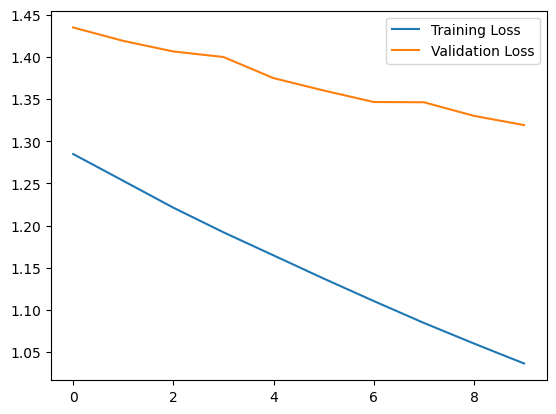

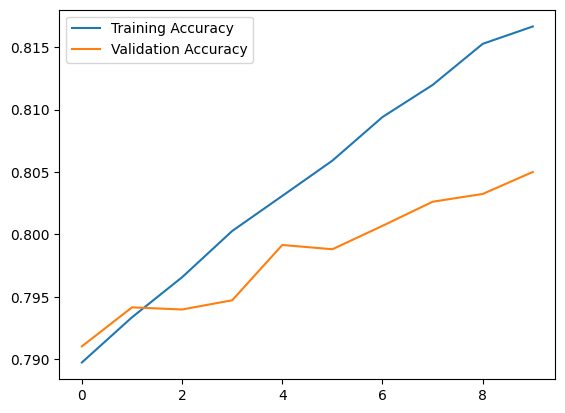

In [13]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()
''' after 10 epoch the train loss and validation loss '''

In [14]:
## now using multi layer sequence model architecture
''' hear use 4 layer of lstm encoder and 4 layer of lstm decoder
train our lstm model with 256 neurons
and adam optimizer use'''


' hear use 4 layer of lstm encoder and 4 layer of lstm decoder '

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, 5)]                  0         []                            
 )                                                                                                
                                                                                                  
 encoder_embedding (Embeddi  (None, 5, 200)               485200    ['encoder_inputs[0][0]']      
 ng)                                                                                              
                                                                                                  
 encoder_lstm1 (LSTM)        [(None, 5, 256),             467968    ['encoder_embedding[0][0]']   
                              (None, 256),                                                  

In [34]:

# Encoder
encoder_inputs = Input(shape=(max_input_len,), name='encoder_inputs')
encoder_embedding = Embedding(num_words, 200, input_length=max_input_len, name='encoder_embedding')(encoder_inputs)

encoder_lstm1 = LSTM(256, return_sequences=True, return_state=True, name='encoder_lstm1')
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

encoder_lstm2 = LSTM(256, return_sequences=True, return_state=True, name='encoder_lstm2')
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)

encoder_lstm3 = LSTM(256, return_sequences=True, return_state=True, name='encoder_lstm3')
encoder_outputs3, state_h3, state_c3 = encoder_lstm3(encoder_outputs2)

encoder_lstm4 = LSTM(256, return_state=True, name='encoder_lstm4')
encoder_outputs4, state_h4, state_c4 = encoder_lstm4(encoder_outputs3)

encoder_states = [state_h4, state_c4]

# Decoder
decoder_inputs = Input(shape=(max_out_len,), name='decoder_inputs')
decoder_embedding = Embedding(num_words_output, 200, name='decoder_embedding')(decoder_inputs)

decoder_lstm1 = LSTM(256, return_sequences=True, return_state=True, name='decoder_lstm1')
decoder_outputs1, _, _ = decoder_lstm1(decoder_embedding, initial_state=encoder_states)

decoder_lstm2 = LSTM(256, return_sequences=True, return_state=True, name='decoder_lstm2')
decoder_outputs2, _, _ = decoder_lstm2(decoder_outputs1)

decoder_lstm3 = LSTM(256, return_sequences=True, return_state=True, name='decoder_lstm3')
decoder_outputs3, _, _ = decoder_lstm3(decoder_outputs2)

decoder_lstm4 = LSTM(256, return_sequences=True, return_state=True, name='decoder_lstm4')
decoder_outputs4, _, _ = decoder_lstm4(decoder_outputs3)

decoder_dense = Dense(num_words_output, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs4)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Fit the model
history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_output_sequences,
    batch_size=40,
    epochs=15,
    validation_split=0.2,
)


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, 5)]                  0         []                            
 )                                                                                                
                                                                                                  
 encoder_embedding (Embeddi  (None, 5, 200)               485200    ['encoder_inputs[0][0]']      
 ng)                                                                                              
                                                                                                  
 encoder_lstm1 (LSTM)        [(None, 5, 256),             467968    ['encoder_embedding[0][0]']   
                              (None, 256),                                                  

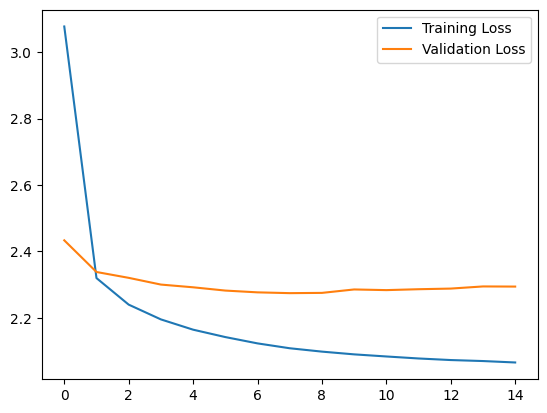

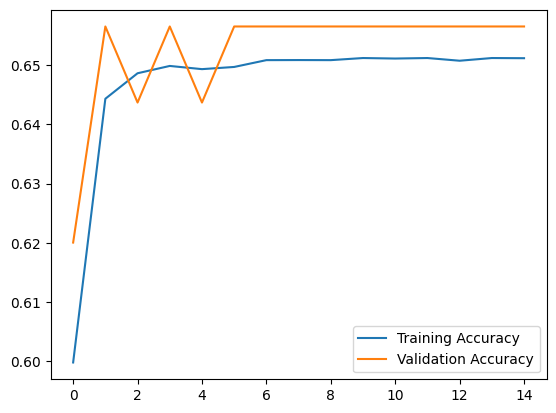

' after 10 epoch the train loss and validation loss '

In [35]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()
''' after 10 epoch the train loss and validation loss '''